# Covid-19: From model prediction to model predictive control

## Calibration of the age-stratified deterministic model

*Original code by Ryan S. McGee. Modified by T.W. Alleman in consultation with the BIOMATH research unit headed by prof. Ingmar Nopens.*

Copyright (c) 2020 by T.W. Alleman, BIOMATH, Ghent University. All Rights Reserved.

This notebook accompanies our preprint: "*A deterministic, age-stratified, extended SEIRD model for assessing the effect of non-pharmaceutical interventions on SARS-CoV-2 spread in Belgium*"(https://doi.org/10.1101/2020.07.17.20156034)

### Load required packages

In [1]:
import random
import os
import numpy as np
import json
import corner
import random

import pandas as pd
import datetime
import scipy
import matplotlib.dates as mdates
import matplotlib
import math
import xarray as xr
import emcee
import matplotlib.pyplot as plt
import datetime

from covid19model.optimization import objective_fcns, pso
from covid19model.models import models
from covid19model.models.utils import draw_sample_COVID19_SEIRD
from covid19model.data import google
from covid19model.data import sciensano
from covid19model.data import model_parameters
from covid19model.visualization.output import population_status, infected
from covid19model.visualization.optimization import plot_fit, traceplot

# OPTIONAL: Load the "autoreload" extension so that package code can change
%load_ext autoreload
# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2

### Load interaction matrices

In [2]:
initN, Nc_home, Nc_work, Nc_schools, Nc_transport, Nc_leisure, Nc_others, Nc_total = model_parameters.get_interaction_matrices(dataset='willem_2012')
levels = initN.size

### Scrape high-level Sciensano data

In [3]:
df_sciensano = sciensano.get_sciensano_COVID19_data(update=False)
df_sciensano.tail()

,H_tot,ICU_tot,H_in,H_out,H_tot_cumsum,D_tot,D_25_44,D_45_64,D_65_74,D_75_84,D_85+
DATE,,,,,,,,,,,
2020-10-29,6187,1057,673,474,4738,132,1.0,7.0,19,49,56
2020-10-30,6438,1105,720,463,4995,160,0.0,11.0,16,67,66
2020-10-31,6501,1161,684,657,5022,120,1.0,7.0,24,42,46
2020-11-01,6823,1223,555,250,5327,98,0.0,10.0,21,31,36
2020-11-02,7231,1302,596,180,5743,26,0.0,3.0,7,9,7


### Initialize the model without time-dependent parameters

In [4]:
def ramp_fun(Nc_old, Nc_new, t, tau_days, l, t_start):
    """
    t : current date
    tau : number of days before measures start having an effect
    l : number of additional days after the time delay until full compliance is reached
    """
    return Nc_old + (Nc_new-Nc_old)/l * (t-t_start-tau_days)/pd.Timedelta('1D')

In [5]:
# Define the compliance and lockdown function
def lockdown_func(t,param,policy1,policy2,l,tau,prevention, start_date, policy_time):
    tau_days = pd.to_timedelta(tau, unit='D')
    l_days = pd.to_timedelta(l, unit='D')
    if t <= start_date + tau_days:
        return policy1
    elif start_date + tau_days < t <= start_date + tau_days + l_days:
        return ramp_fun(policy1, policy2, t, tau_days, l, start_date)
    else:
        return prevention*policy2

In [6]:
# Load the parameters using `get_COVID19_SEIRD_parameters()`.
params = model_parameters.get_COVID19_SEIRD_parameters()
params.update({'policy1': Nc_total,
              'policy2': 1.0*Nc_home + (1-0.60)*Nc_work + (1-0.70)*Nc_transport + (1-0.30)*Nc_others + (1-0.80)*Nc_leisure,
              'policy_time': 500,
              'l': 1,
              'tau': 5,
              'prevention': 0.5,
              'start_date': pd.to_datetime('2020-03-15')})
# Define the initial condition: one exposed inidividual in every age category
initial_states = {'S': initN, 'E': np.ones(levels)}
model = models.COVID19_SEIRD(initial_states, params, time_dependent_parameters={'Nc': lockdown_func})

### Calibrating $\beta$ and lag_time

**Go to next section if posterior samples are available**

Use the function `fit_pso` to obtain a good starting estimate for the MCMC sampler.

In [10]:
# Date of first data collection
start_date = '2020-03-15'
# Last datapoint used to calibrate basic reproduction number
end_beta = '2020-03-25'
# Last datapoint used to calibrate the compliance ramp
end_ramp = '2020-04-25'
# Path where figures should be stored
fig_path = '../results/calibrations/COVID19_SEIRD/national/'
# Path where MCMC samples should be saved
samples_path = '../data/interim/model_parameters/COVID19_SEIRD/calibration/national/'
# Spatial unit: Belgium
spatial_unit = 'BE'

In [11]:
from covid19model.optimization.run_optimization import full_calibration_wave1
samples_dict = full_calibration_wave1(model, df_sciensano['H_in'], spatial_unit, start_date, end_beta, end_ramp, 
                                fig_path=fig_path, samples_path=samples_path,
                                initN=initN, Nc_total=Nc_total,
                                maxiter=10, popsize=10, steps_mcmc=300, discard=30)

---------------------------
CALIBRATING BETA AND WARMUP
---------------------------

1) Particle swarm optimization

No constraints given.
New best for swarm at iteration 1: [9.12691504e+01 3.00000000e+01 5.51960712e-02] 74.32830873171329
Best after iteration 1: [9.12691504e+01 3.00000000e+01 5.51960712e-02] 74.32830873171329
New best for swarm at iteration 2: [1.e+02 3.e+01 6.e-02] 57.313453809746164
Best after iteration 2: [1.e+02 3.e+01 6.e-02] 57.313453809746164
Best after iteration 3: [1.e+02 3.e+01 6.e-02] 57.313453809746164
Best after iteration 4: [1.e+02 3.e+01 6.e-02] 57.313453809746164
New best for swarm at iteration 5: [1.00000000e+02 4.33158112e+01 4.31098476e-02] 54.28591206944769
Best after iteration 5: [1.00000000e+02 4.33158112e+01 4.31098476e-02] 54.28591206944769
New best for swarm at iteration 6: [1.00000000e+02 3.15166071e+01 5.83481887e-02] 53.39823319062385
Best after iteration 6: [1.00000000e+02 3.15166071e+01 5.83481887e-02] 53.39823319062385
New best for swarm 

  0%|          | 0/300 [00:00<?, ?it/s]

Best after iteration 10: [1.00000000e+02 3.27298927e+01 5.70267397e-02] 53.195158308221714
Stopping search: maximum iterations reached --> 10

2) Markov-Chain Monte-Carlo sampling



100%|██████████| 300/300 [00:41<00:00,  7.14it/s]


Use this estimate with caution and run a longer chain!
---------------------------------------------------------------------------------------------------------

CALIBRATING COMPLIANCE RAMP
---------------------------

1) Particle swarm optimization


2) Markov-Chain Monte-Carlo sampling

No constraints given.
New best for swarm at iteration 1: [100.          12.65412282  20.           0.52329953] 479.4484690636089
Best after iteration 1: [100.          12.65412282  20.           0.52329953] 479.4484690636089
New best for swarm at iteration 2: [100.          12.87779019  20.           0.87614736] 477.5903040422948
Best after iteration 2: [100.          12.87779019  20.           0.87614736] 477.5903040422948
New best for swarm at iteration 3: [100.          13.23184811  20.           0.91779668] 477.24869898054925
Best after iteration 3: [100.          13.23184811  20.           0.91779668] 477.24869898054925
New best for swarm at iteration 4: [100.          19.62763282  20.           

  0%|          | 0/300 [00:00<?, ?it/s]/home/twallema/anaconda3/envs/COVID_MODEL/lib/python3.8/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
/home/twallema/anaconda3/envs/COVID_MODEL/lib/python3.8/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
/home/twallema/anaconda3/envs/COVID_MODEL/lib/python3.8/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
/home/twallema/anaconda3/envs/COVID_MODEL/lib/python3.8/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
  1%|▏         | 4/300 [00:00<00:10, 27.91it/s]

Best after iteration 10: [100.  20.  20.   1.] 474.5939127552604
Stopping search: maximum iterations reached --> 10


/home/twallema/anaconda3/envs/COVID_MODEL/lib/python3.8/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
/home/twallema/anaconda3/envs/COVID_MODEL/lib/python3.8/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
  3%|▎         | 8/300 [00:00<00:09, 30.68it/s]/home/twallema/anaconda3/envs/COVID_MODEL/lib/python3.8/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
/home/twallema/anaconda3/envs/COVID_MODEL/lib/python3.8/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
/home/twallema/anaconda3/envs/COVID_MODEL/lib/python3.8/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  l

 19%|█▉        | 58/300 [00:02<00:22, 10.96it/s]/home/twallema/anaconda3/envs/COVID_MODEL/lib/python3.8/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
/home/twallema/anaconda3/envs/COVID_MODEL/lib/python3.8/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
 20%|██        | 60/300 [00:02<00:21, 11.35it/s]/home/twallema/anaconda3/envs/COVID_MODEL/lib/python3.8/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
/home/twallema/anaconda3/envs/COVID_MODEL/lib/python3.8/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
/home/twallema/anaconda3/envs/COVID_MODEL/lib/python3.8/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning

---------------------------------------------------------------------------------------------------------

DONE

SAMPLES DICTIONARY SAVED IN "../data/interim/model_parameters/COVID19_SEIRD/calibration/national/BE_2020-11-05.json"


In [9]:
# define dataset
data=[df_sciensano["H_in"][start_date:end_beta]]
# set optimisation settings
parNames = ['sigma_H_in','warmup','beta'] # must be a list!
states = [["H_in"]]
bounds=((1,100),(30,60),(0.02,0.06)) # must be a list!
# run optimisation
theta = MCMC.fit_pso(model,data,parNames,states,bounds,maxiter=100,popsize=20,start_date=start_date)

No constraints given.
New best for swarm at iteration 1: [9.25868148e+01 4.18997107e+01 4.58112629e-02] 52.960798780557326
Best after iteration 1: [9.25868148e+01 4.18997107e+01 4.58112629e-02] 52.960798780557326
Best after iteration 2: [9.25868148e+01 4.18997107e+01 4.58112629e-02] 52.960798780557326
New best for swarm at iteration 3: [7.36362589e+01 4.46486213e+01 4.28962348e-02] 51.272353191078665
Best after iteration 3: [7.36362589e+01 4.46486213e+01 4.28962348e-02] 51.272353191078665
Best after iteration 4: [7.36362589e+01 4.46486213e+01 4.28962348e-02] 51.272353191078665
Best after iteration 5: [7.36362589e+01 4.46486213e+01 4.28962348e-02] 51.272353191078665
Best after iteration 6: [7.36362589e+01 4.46486213e+01 4.28962348e-02] 51.272353191078665
New best for swarm at iteration 7: [6.77889358e+01 4.61683983e+01 4.16632635e-02] 49.85671732270416
Best after iteration 7: [6.77889358e+01 4.61683983e+01 4.16632635e-02] 49.85671732270416
Best after iteration 8: [6.77889358e+01 4.61683

Best after iteration 75: [5.30287535e+01 4.73639029e+01 4.07865676e-02] 49.17667806251468
New best for swarm at iteration 76: [5.30244921e+01 4.73680255e+01 4.07864907e-02] 49.176677928352674
Best after iteration 76: [5.30244921e+01 4.73680255e+01 4.07864907e-02] 49.176677928352674
New best for swarm at iteration 77: [5.30210667e+01 4.73770556e+01 4.07867217e-02] 49.17667751823213
Best after iteration 77: [5.30210667e+01 4.73770556e+01 4.07867217e-02] 49.17667751823213
Best after iteration 78: [5.30210667e+01 4.73770556e+01 4.07867217e-02] 49.17667751823213
Best after iteration 79: [5.30210667e+01 4.73770556e+01 4.07867217e-02] 49.17667751823213
Best after iteration 80: [5.30210667e+01 4.73770556e+01 4.07867217e-02] 49.17667751823213
Best after iteration 81: [5.30210667e+01 4.73770556e+01 4.07867217e-02] 49.17667751823213
New best for swarm at iteration 82: [5.30214159e+01 4.73731037e+01 4.07866272e-02] 49.176677507300155
Best after iteration 82: [5.30214159e+01 4.73731037e+01 4.078662

In [10]:
# Assign 'warmup' --> is needed to further the optimalization
warmup = int(round(theta[1]))

Initiatize and run the MCMC sampler

In [11]:
parNames = ['sigma_ICU','beta'] # must be a list!
bounds=((1,200),(0.01,0.10))
# Initialise starting position of sampler based on PSO estimate
pos = [theta[0],theta[2]] + [1, 1e-3 ]* np.random.randn(4, 2)
nwalkers, ndim = pos.shape
sampler = emcee.EnsembleSampler(nwalkers, ndim, objective_fcns.log_probability,
                                args=(model,bounds,data,states,parNames,None,start_date,warmup))
sampler.run_mcmc(pos, 500, progress=True);

100%|██████████| 500/500 [01:19<00:00,  6.30it/s]


In [29]:
samples = sampler.get_chain(discard=0,flat=False)
flat_samples = sampler.get_chain(discard=0,flat=True)

In [13]:
# Calculate the autocorrelation time
try:
    print(sampler.get_autocorr_time())
except:
    print('The chain is shorter than 50 times the integrated autocorrelation time.')

The chain is shorter than 50 times the integrated autocorrelation time.


Initialize a dictionary with the posterior samples and write them to `parameters_deterministic.json`

Make a traceplot and cornerplot of the posterior samples

In [16]:
from covid19model.optimization.run_optimization import checkplots, calculate_R0

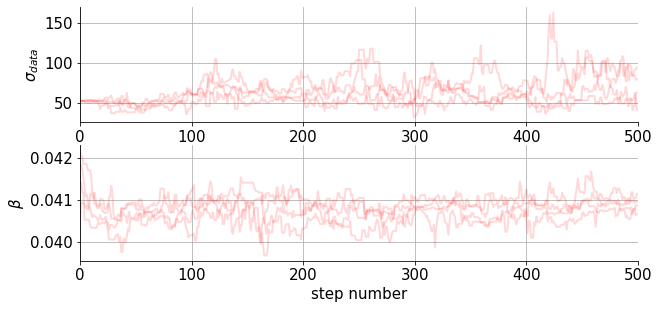

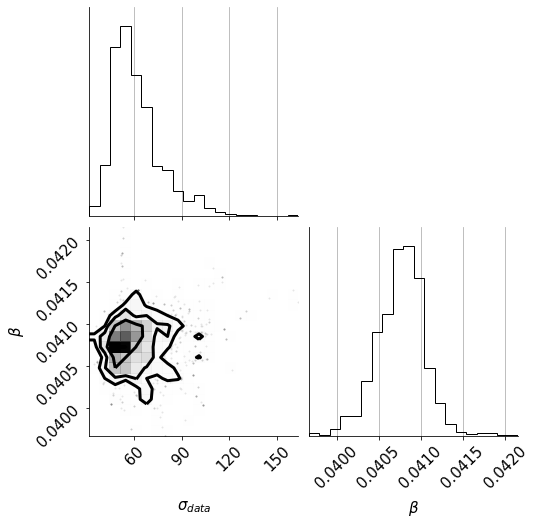

In [17]:
checkplots(samples_beta, flat_samples_beta, fig_path, 'Belgium', 
                figname='beta_', labels=['$\sigma_{data}$','$\\beta$'])

In [1]:
R0, R0_stratified = calculate_R0(samples_dict, model, initN, Nc_total)

NameError: name 'calculate_R0' is not defined

Make a visualisation of the data and model prediction

<ipython-input-35-e52a7922fb6f>:10: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "papertype" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('../results/calibration_non_spatial_deterministic/plot_fit_beta.pdf', dpi=600, bbox_inches='tight',orientation='portrait', papertype='a4')


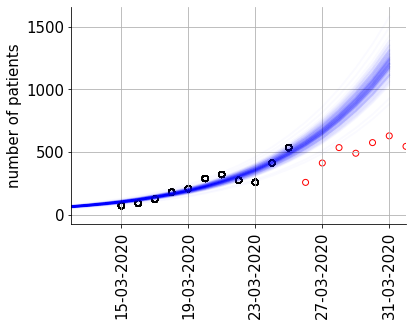

In [35]:
T = 6
fig,ax=plt.subplots()

for i in range(200):
    model.parameters['beta'] = np.random.choice(samples_dict['beta'],1,replace=False)
    y_model = model.sim(data[0].size+samples_dict['lag_time']-1+T)
    ax = plot_fit(y_model,data,start_date,samples_dict['lag_time'],states,T=T,ax=ax,plt_kwargs={'color':'blue','linewidth': 2,'alpha': 0.02})

plt.scatter(pd.date_range('15-03-2020',freq='D',periods=df_sciensano["H_in"][8:18].size)+datetime.timedelta(days=data[0].size),df_sciensano["H_in"][8:18], marker='o',color='red',linestyle='None',facecolors='none')
plt.savefig('../results/calibration_non_spatial_deterministic/plot_fit_beta.pdf', dpi=600, bbox_inches='tight',orientation='portrait', papertype='a4')

In [37]:
samples_dict={'warmup': int(round(theta[1])), 'beta': flat_samples[:,1].tolist()}

In [29]:
with open('../data/interim/model_parameters/deterministic_'+datetime.datetime.today().strftime('%Y-%m-%d') +'.json', 'w') as fp:
    json.dump(samples_dict, fp)

### Calibrating the compliance ramp parameters

In [36]:
# Load previous samples
with open('../data/interim/model_parameters/deterministic_'+datetime.datetime.today().strftime('%Y-%m-%d') +'.json', 'r') as fp:
    samples_dict = json.load(fp)

Define the social policy change + two parameter ramp compliance

In [37]:
# Define the compliance and lockdown function
def lockdown_func(t,param,policy_time,policy1,policy2,l,tau,prevention):
    if t <= policy_time + tau:
        return policy1
    elif policy_time + tau < t <= policy_time + tau + l:
        return policy1 + (prevention*policy2-policy1)/l*(t-policy_time-tau)
    else:
        return prevention*policy2

In [38]:
# Load the parameters using `get_COVID19_SEIRD_parameters()`.
params = model_parameters.get_COVID19_SEIRD_parameters()
# Define the initial condition: one exposed inidividual in every age category
initial_states = {'S': initN, 'E': np.ones(levels)}

Update the parameter dictionary

In [39]:
params.update({'policy1': Nc_total,
              'policy2': 1.0*Nc_home + (1-0.60)*Nc_work + (1-0.70)*Nc_transport + (1-0.30)*Nc_others + (1-0.80)*Nc_leisure,
              'policy_time': samples_dict['lag_time'],
              'l': 1,
              'tau': 5,
              'prevention': 0.5})

Initialize the model

In [40]:
model = models.COVID19_SEIRD(initial_states, params, time_dependent_parameters={'Nc': lockdown_func})

Load the previously calibrated parameters.

In [41]:
model.extraTime = samples_dict['lag_time']
model.parameters['beta'] = np.mean(samples_dict['beta'])

In [42]:
samples_beta = {'beta': samples_dict['beta']}

Find an initial guess for the MCMC sampler by using PSO

In [43]:
# define dataset
data=[df_sciensano["H_in"].values[:60]]
# set optimisation settings
parNames = ['sigma_H_in','l','tau','prevention'] # must be a list!
states = [["H_in"]]
bounds=((1,200),(0.1,20),(0.1,20),(0,0.8)) # must be a list!
# run optimisation
theta = MCMC.fit_pso(model,data,parNames,states,bounds,samples=samples_beta,maxiter=100,popsize=100)

No constraints given.
Best after iteration 1: [88.79145831 13.48630976  0.3210387   0.41857126] 281.03921713222087
Best after iteration 2: [88.79145831 13.48630976  0.3210387   0.41857126] 281.03921713222087
Best after iteration 3: [88.79145831 13.48630976  0.3210387   0.41857126] 281.03921713222087
Best after iteration 4: [88.79145831 13.48630976  0.3210387   0.41857126] 281.03921713222087
New best for swarm at iteration 5: [71.004281   12.11685097  0.75039014  0.42012571] 272.2752645542522
Best after iteration 5: [71.004281   12.11685097  0.75039014  0.42012571] 272.2752645542522
Best after iteration 6: [71.004281   12.11685097  0.75039014  0.42012571] 272.2752645542522
Best after iteration 7: [71.004281   12.11685097  0.75039014  0.42012571] 272.2752645542522
Best after iteration 8: [71.004281   12.11685097  0.75039014  0.42012571] 272.2752645542522
Best after iteration 9: [71.004281   12.11685097  0.75039014  0.42012571] 272.2752645542522
New best for swarm at iteration 10: [62.295

Best after iteration 78: [48.28748524  8.75077662  2.25700428  0.39220829] 261.531954744133
Best after iteration 79: [48.28748524  8.75077662  2.25700428  0.39220829] 261.531954744133
Best after iteration 80: [48.28748524  8.75077662  2.25700428  0.39220829] 261.531954744133
Best after iteration 81: [48.28748524  8.75077662  2.25700428  0.39220829] 261.531954744133
Best after iteration 82: [48.28748524  8.75077662  2.25700428  0.39220829] 261.531954744133
Best after iteration 83: [48.28748524  8.75077662  2.25700428  0.39220829] 261.531954744133
Best after iteration 84: [48.28748524  8.75077662  2.25700428  0.39220829] 261.531954744133
Best after iteration 85: [48.28748524  8.75077662  2.25700428  0.39220829] 261.531954744133
New best for swarm at iteration 86: [47.91862523  8.70034739  2.23726529  0.3973716 ] 261.5086627405938
Best after iteration 86: [47.91862523  8.70034739  2.23726529  0.3973716 ] 261.5086627405938
New best for swarm at iteration 87: [47.6379287   8.69102039  2.298

In [44]:
model.parameters.update({
    'l': theta[1],
    'tau': theta[2],
    'prevention': theta[3]
}
)

Initialize and run the MCMC sampler

In [45]:
bounds=((1,100),(0.001,20),(0,20),(0,1)) # must be a list!
pos = theta + [1, 0.01, 0.01, 0.1 ]* np.random.randn(8, 4)
nwalkers, ndim = pos.shape
sampler = emcee.EnsembleSampler(nwalkers, ndim, objective_fcns.log_probability,
                                args=(model,bounds,data,states,parNames,samples_beta))
sampler.run_mcmc(pos, 12000, progress=True);

100%|██████████| 12000/12000 [55:56<00:00,  3.58it/s]


In [46]:
# Calculate the autocorrelation time
try:
    print(sampler.get_autocorr_time())
except:
    print('The chain is shorter than 50 times the integrated autocorrelation time.')

[60.72756972 93.47529206 95.88391274 78.4743932 ]


In [47]:
samples = sampler.get_chain(discard=200,flat=False)
flat_samples = sampler.get_chain(discard=200,flat=True)

Append posterior samples to the samples dictionary

In [48]:
samples_dict.update({'l': flat_samples[:,1].tolist(),'tau':flat_samples[:,2].tolist(),'prevention':flat_samples[:,3].tolist()})

In [49]:
with open('../data/interim/model_parameters/deterministic_'+ datetime.datetime.today().strftime('%Y-%m-%d')+'.json', 'w') as fp:
    json.dump(samples_dict, fp)

In [50]:
# Calculate mean, percentile 10 and percentile 90 of samples
# index 0 --> sigma_{data}
# index 3 --> prevention
print(np.mean(flat_samples[:,1]),np.percentile(flat_samples[:,1],10),np.percentile(flat_samples[:,1],90))

3.0645453776261196 0.5466707509413362 6.274560727221484


<AxesSubplot:xlabel='step number', ylabel='prevention'>

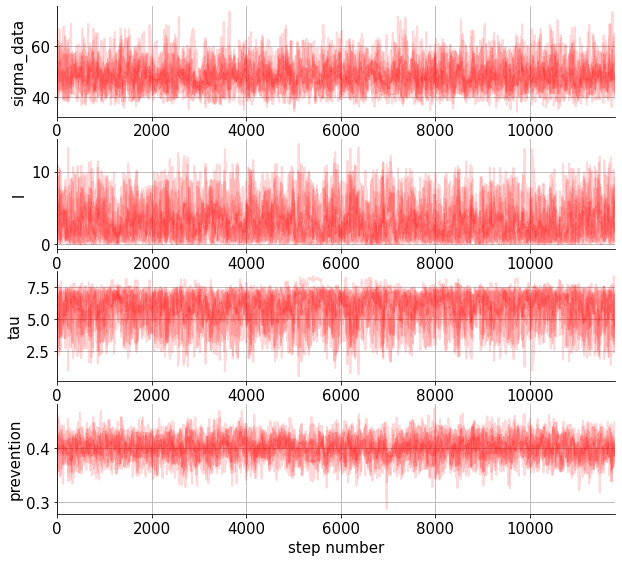

In [51]:
traceplot(samples=sampler.get_chain(discard=200),labels=["sigma_data","l","tau","prevention"],plt_kwargs={'linewidth':2,'color': 'red','alpha': 0.15})

<ipython-input-52-e758e7af66bd>:5: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "papertype" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('../results/calibration_non_spatial_deterministic/corner_compliance_delayed_ramp.pdf', dpi=600, bbox_inches='tight',


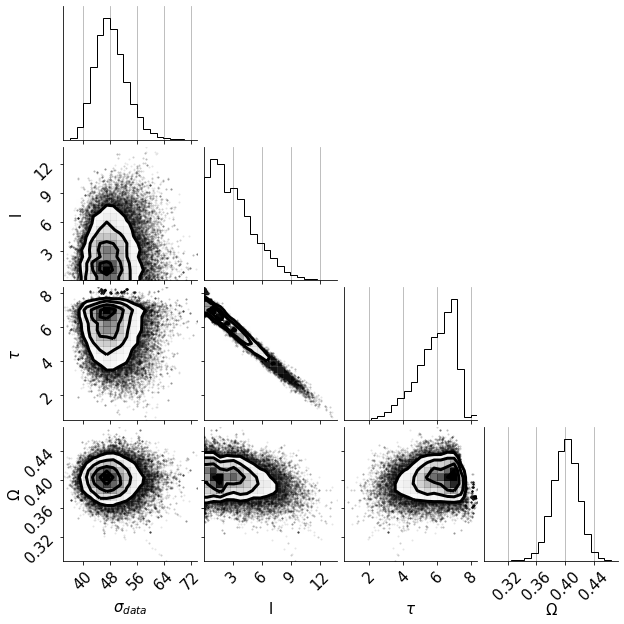

In [52]:
fig = corner.corner(
    flat_samples, labels=["$\sigma_{data}$","l","$\\tau$","$\Omega$"],
);
fig.set_size_inches(9, 9)
plt.savefig('../results/calibration_non_spatial_deterministic/corner_compliance_delayed_ramp.pdf', dpi=600, bbox_inches='tight',
                    orientation='portrait', papertype='a4')

In [20]:
MC_out = model.sim(100,N=100,draw_fcn=draw_sample_COVID19_SEIRD,samples=samples_dict)

<ipython-input-53-4f63e1721517>:16: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "papertype" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('../results/calibration_non_spatial_deterministic/plot_fit_compliance.pdf', dpi=600, bbox_inches='tight',orientation='portrait', papertype='a4')


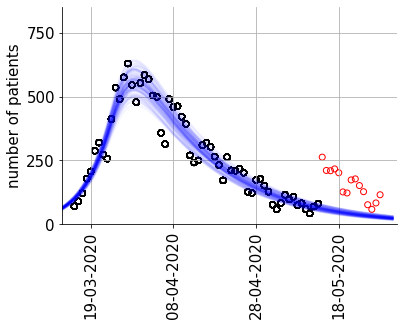

In [53]:
T = 18
start_date = '15-03-2020'
fig,ax=plt.subplots()
for i in range(100):
    idx,model.parameters['beta'] = random.choice(list(enumerate(samples_dict['beta'])))
    idx,model.parameters['l'] = random.choice(list(enumerate(flat_samples[:,1])))
    model.parameters['tau'] = samples_dict['tau'][idx]
    model.parameters['prevention'] = samples_dict['prevention'][idx]
    y_model = model.sim(data[0].size+samples_dict['lag_time']-1+T)
    ax = plot_fit(y_model,data,start_date,samples_dict['lag_time'],states,T=T,ax=ax,plt_kwargs={'color':'blue','linewidth': 2,'alpha': 0.04})

plt.scatter(pd.date_range('15-03-2020',freq='D',periods=df_sciensano["H_in"][37:52].size)+datetime.timedelta(days=data[0].size),df_sciensano["H_in"][37:52], marker='o',color='red',linestyle='None',facecolors='none')
legend_text=['daily \nhospitalizations']
#leg=ax.legend(legend_text, loc="upper left", bbox_to_anchor=(1,1))
ax.set_ylim([0,850])
plt.savefig('../results/calibration_non_spatial_deterministic/plot_fit_compliance.pdf', dpi=600, bbox_inches='tight',orientation='portrait', papertype='a4')

### Computation of the basic reproduction number

2.6126337631592857 2.5947845285782063 2.630083878558955


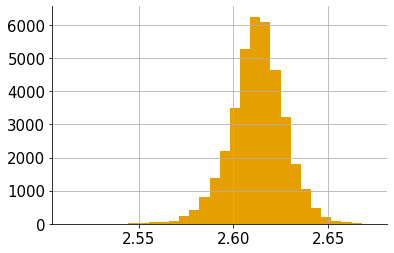

In [54]:
R_0 =[]
for i in range(len(samples_dict['beta'])):
    R_0.append(sum((model.parameters['a']*model.parameters['da']+model.parameters['omega'])*samples_dict['beta'][i]*model.parameters['s']*np.sum(Nc_total,axis=1)*(initN/sum(initN))))

plt.hist(R_0,bins=30)
mean = np.mean(R_0)
p10 = np.percentile(R_0,10)
p90 = np.percentile(R_0,90)
print(mean,p10,p90)

1.4839423489394419 1.4738042134439455 1.4938537898771633
2.019899961672233 2.0061002210600605 2.0333911321240556
3.9163904003336523 3.8896340397781213 3.9425484732329856
4.530193140694987 4.499243345432416 4.560450880682366
3.7408171509708383 3.7152602880862893 3.7658025476590318
2.724041368585598 2.7054310091536458 2.742235589645427
1.4918781757928299 1.4816858235766055 1.501842621134129
0.8597047149087493 0.8538313041983592 0.8654467927676285
0.7238265155353555 0.7188814101577945 0.7286610455041325


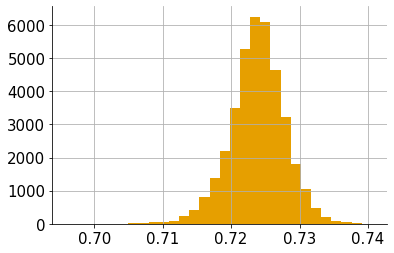

In [55]:
R_0 = np.zeros([initN.size,len(samples_dict['beta'])])
for i in range(len(samples_dict['beta'])):
    R_0[:,i]= (model.parameters['a']*model.parameters['da']+model.parameters['omega'])*samples_dict['beta'][i]*model.parameters['s']*np.sum(Nc_total,axis=1)
plt.hist(R_0[8,:],bins=30)

for i in range(R_0.shape[0]):
    mean = np.mean(R_0[i,:])
    p10 = np.percentile(R_0[i,:],10)
    p90 = np.percentile(R_0[i,:],90)
    print(mean,p10,p90)

### Visualisations used in the preprint

Load the posterior samples

In [7]:
# Load previous samples
with open('../data/interim/model_parameters/deterministic_'+datetime.datetime.today().strftime('%Y-%m-%d') +'.json', 'r') as fp:
    samples_dict = json.load(fp)

model.extraTime = samples_dict['lag_time']
model.parameters['beta'] = np.mean(samples_dict['beta'])
model.parameters['l'] = np.mean(samples_dict['l'])
model.parameters['tau'] = np.mean(samples_dict['tau'])
model.parameters['prevention'] = np.mean(samples_dict['prevention'])

#### Cumulative hospitalizations

TypeError: integrate() takes 35 positional arguments but 38 were given

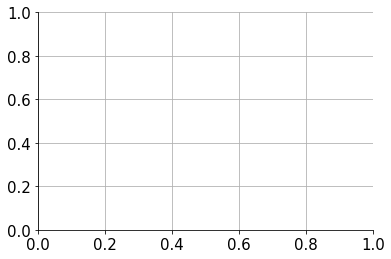

In [8]:
from covid19model.visualization.output import _apply_tick_locator

# define dataset
data=[df_sciensano["H_in"].values[:51]]
states = [["H_in"]]
start_date = '15-03-2020'

T = 2

fig,ax=plt.subplots()
for i in range(300):
    model.parameters['beta'] = np.random.choice(samples_dict['beta'],1,replace=False)
    idx,model.parameters['l'] = random.choice(list(enumerate(samples_dict['l'])))
    model.parameters['tau'] = samples_dict['tau'][idx]
    model.parameters['prevention'] = samples_dict['prevention'][idx]
    y_model = model.sim(data[0].size+samples_dict['lag_time']-1+T)
    
    # Create shifted index vector 
    idx = pd.date_range(start_date,freq='D',periods=data[0].size + samples_dict['lag_time'] + T) - datetime.timedelta(days=samples_dict['lag_time'])
    # Plot model prediction

    lines = ax.plot([],[],color='red',alpha=1)
    lines = ax.plot([],[],color='blue',alpha=1)
    
    for i in range(len(data)): 
        # ages 70 plus
        data2plot = y_model[states[i]].to_array(dim="states").values.ravel()
        val = y_model[states[i]].to_array(dim="states").values[:,7:,:].sum(axis=1)
        csum=np.cumsum(val)
        lines = ax.plot(idx,csum,color='blue',linewidth= 2,alpha= 0.05)    
        # total cumsum
        data2plot = y_model[states[i]].to_array(dim="states").values.ravel()
        val = y_model[states[i]].to_array(dim="states").values.sum(axis=1)
        csum=np.cumsum(val)
        lines = ax.plot(idx,csum,color='red',linewidth= 2,alpha= 0.05)  
    # Plot data
    for i in range(len(data)):
        lines=ax.scatter(idx[samples_dict['lag_time']:-T],np.cumsum(data[i]),color="black",facecolors='none')
    
    # Format axes
    ax.xaxis.set_major_locator(mdates.DayLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))
    plt.setp(plt.gca().xaxis.get_majorticklabels(),
        'rotation', 90)
    #fig.autofmt_xdate(rotation=90)
    ax.set_xlim( idx[samples_dict['lag_time']-3], pd.to_datetime(idx[-1]+ datetime.timedelta(days=1)))
    ax.set_ylabel('number of patients')

    # limit the number of ticks on the axis
    ax = _apply_tick_locator(ax)

legend_text=['Total hospitalizations','Total hospitalizations \n(ages 70+)']
leg=ax.legend(legend_text, loc="upper left", bbox_to_anchor=(1,1))
for lh in leg.get_lines(): 
    lh.set_alpha(1)
fig.set_size_inches(10, 4)
plt.savefig('../results/calibration_non_spatial_deterministic/hospital_age.pdf', dpi=300, bbox_inches='tight',orientation='portrait', papertype='a4')

#### Continuation of lockdown

In [9]:
data=[df_sciensano["H_tot"].values,df_sciensano["ICU_tot"].values]
states = [["H_tot"],["ICU"]]

In [24]:
# Define data as a list containing data timeseries
index = pd.date_range('15-03-2020',freq='D',periods = data[0].size + samples_dict['lag_time'] + 500)
print(index[1])
print(index[50])
print(index[52])
print(index[57])
print(index[64])
print(index[81])
print(index[108])
print(index[170])
print(index[232])
print(index[239])
print(index[281])
print(index[292])
print(index[337])
print(index[343])

2020-03-16 00:00:00
2020-05-04 00:00:00
2020-05-06 00:00:00
2020-05-11 00:00:00
2020-05-18 00:00:00
2020-06-04 00:00:00
2020-07-01 00:00:00
2020-09-01 00:00:00
2020-11-02 00:00:00
2020-11-09 00:00:00
2020-12-21 00:00:00
2021-01-01 00:00:00
2021-02-15 00:00:00
2021-02-21 00:00:00


<ipython-input-41-13d1ed244d11>:16: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "papertype" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('../results/calibration_non_spatial_deterministic/continued_lockdown.pdf', dpi=300, bbox_inches='tight',orientation='portrait', papertype='a4')


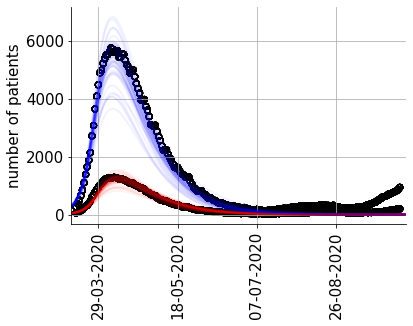

In [41]:
T = 3

fig,ax=plt.subplots()

for i in range(50):
    model.parameters['beta'] = np.random.choice(samples_dict['beta'],1,replace=False)
    idx,model.parameters['l'] = random.choice(list(enumerate(samples_dict['l'])))
    model.parameters['tau'] = samples_dict['tau'][idx]
    model.parameters['prevention'] = samples_dict['prevention'][idx]
    y_model = model.sim(data[0].size+samples_dict['lag_time']-1+T)
    ax = plot_fit(y_model,data,'15-03-2020',samples_dict['lag_time'],states,T=T,ax=ax,
                  legend_text=None,
                  plt_kwargs={'linewidth': 2,'alpha': 0.05})

legend_text=['Hospital (total)','ICU (total)']
plt.savefig('../results/calibration_non_spatial_deterministic/continued_lockdown.pdf', dpi=300, bbox_inches='tight',orientation='portrait', papertype='a4')

#### Lockdown release

In [42]:
def lockdown_release_func(t,param,policy_time,policy1,policy2,policy3,policy4,policy5,policy6,policy7,policy8,policy9,l,tau,prevention):
    if t <= policy_time + tau:
        return policy1
    elif policy_time + tau < t <= policy_time + tau + l:
        return policy1 + (prevention*policy2-policy1)/l*(t-policy_time-tau)
    elif policy_time + tau + l < t <= policy_time + 50: 
        return prevention*policy2
    elif policy_time + 50 < t <= policy_time + 52:
        return prevention*policy3
    elif policy_time + 52 < t <= policy_time + 57:
        return prevention*policy4
    elif policy_time + 57 < t <= policy_time + 64:
        return prevention*policy5
    elif policy_time + 64 < t <= policy_time + 81:
        return prevention*policy6
    elif policy_time + 81 < t <= policy_time + 108:
        return prevention*policy7
    elif policy_time + 108 < t <= policy_time + 170:
        return prevention*policy8
    else:
        return prevention*policy9

In [43]:
params.update({'policy1': Nc_total,
              'policy2': 1.0*Nc_home + (1-0.60)*Nc_work + (1-0.70)*Nc_transport + (1-0.30)*Nc_others + (1-0.80)*Nc_leisure,
              'policy3': 1.0*Nc_home + (1-0.50)*Nc_work + (1-0.60)*Nc_transport + (1-0.30)*Nc_others + (1-0.70)*Nc_leisure,
              'policy4': 1.0*Nc_home + (1-0.40)*Nc_work + (1-0.55)*Nc_transport + (1-0.25)*Nc_others + (1-0.65)*Nc_leisure,
              'policy5': 1.0*Nc_home + (1-0.30)*Nc_work + (1-0.50)*Nc_transport + (1-0.20)*Nc_others + (1-0.60)*Nc_leisure,
              'policy6': 1.0*Nc_home + (1-0.30)*Nc_work + (1-0.45)*Nc_transport + (1-0.15)*Nc_others + (1-0.85)*Nc_schools + (1-0.50)*Nc_leisure,
              'policy7': 1.0*Nc_home + (1-0.25)*Nc_work + (1-0.35)*Nc_transport + (1-0.10)*Nc_others + (1-0.35)*Nc_schools + (1-0.30)*Nc_leisure,
              'policy8': 1.0*Nc_home + (1-0.20)*Nc_work + (1-0.15)*Nc_transport + (1-0.00)*Nc_others + (1-0.00)*Nc_leisure,
              'policy9': 1.0*Nc_home + (1-0.10)*Nc_work + (1-0.15)*Nc_transport + (1-0.00)*Nc_others + (1-0.00)*Nc_schools + (1-0.00)*Nc_leisure,
               'policy_time': samples_dict['lag_time'],
              'l': 1,
              'tau': 5,
              'prevention': 0.5})

In [44]:
model_lr = models.COVID19_SEIRD(initial_states, params, time_dependent_parameters={'Nc': lockdown_release_func})

<ipython-input-45-7fbe876e1433>:26: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "papertype" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('../results/calibration_non_spatial_deterministic/lockdown_release.pdf', dpi=300, bbox_inches='tight',orientation='portrait', papertype='a4')


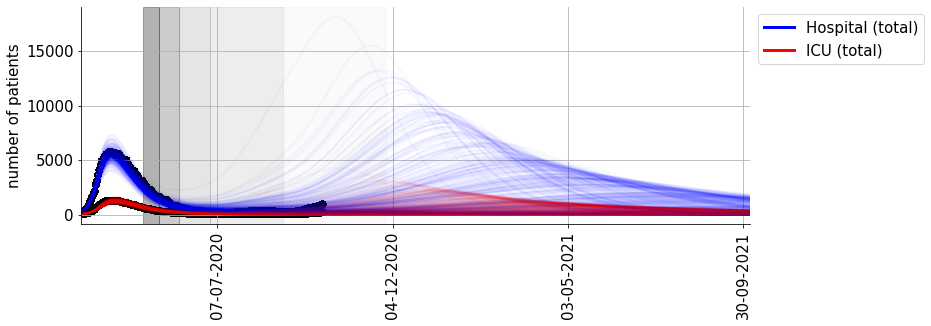

In [45]:
T = 365

fig,ax=plt.subplots()
fig.set_size_inches(12, 4)

ax.axvspan(index[50], index[64], alpha=0.30, color='black') # 11 mei
ax.axvspan(index[64], index[81], alpha=0.20, color='black') # 1 juni
ax.axvspan(index[81], index[108], alpha=0.10, color='black') # 1 juli
ax.axvspan(index[108], index[170], alpha=0.05, color='black') # 1 sept
ax.axvspan(index[108], index[-1], alpha=0.02, color='black') # 1 sept

for i in range(300):
    model_lr.parameters['beta'] = np.random.choice(samples_dict['beta'],1,replace=False)
    idx,model_lr.parameters['l'] = random.choice(list(enumerate(samples_dict['l'])))
    model_lr.parameters['tau'] = samples_dict['tau'][idx]
    model_lr.parameters['prevention'] = samples_dict['prevention'][idx]
    y_model = model_lr.sim(data[0].size+samples_dict['lag_time']-1+T)
    ax = plot_fit(y_model,data,'15-03-2020',samples_dict['lag_time'],states,T=T,ax=ax,
                  legend_text=None,
                  plt_kwargs={'linewidth': 2,'alpha': 0.03})

legend_text=['Hospital (total)','ICU (total)']
leg=ax.legend(legend_text, loc="upper left", bbox_to_anchor=(1,1))
for lh in leg.get_lines(): 
    lh.set_alpha(1)
plt.savefig('../results/calibration_non_spatial_deterministic/lockdown_release.pdf', dpi=300, bbox_inches='tight',orientation='portrait', papertype='a4')

#### Seroprelevance

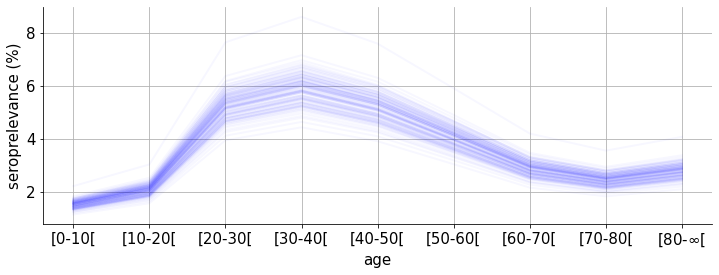

In [46]:
fig,ax=plt.subplots()
for i in range(100):
    model.parameters['beta'] = np.random.choice(samples_dict['beta'],1,replace=False)
    idx,model.parameters['l'] = random.choice(list(enumerate(samples_dict['l'])))
    model.parameters['tau'] = samples_dict['tau'][idx]
    model.parameters['prevention'] = samples_dict['prevention'][idx]
    y_model = model.sim(data[0].size+samples_dict['lag_time']-1+T)
    ax.plot((1-y_model["S"][:,samples_dict['lag_time']+36]/y_model["S"][:,0])*100,alpha=0.03,color='blue',linewidth=2)
ax.set_xlabel('age')
ax.set_ylabel("seroprelevance (%)" )
plt.xticks(np.arange(9), ('[0-10[', '[10-20[', '[20-30[', '[30-40[', '[40-50[', '[50-60[', '[60-70[', '[70-80[', '[80-$\infty$['))
fig.set_size_inches(12, 4)

#### Basic reproduction number vs expected hospitalisations

1.6395334651043612 1.622569369942288 1.6555066290368379
2.231686147168368 2.2085951051260917 2.253428361910102
4.327023302724359 4.2822520085493725 4.369179351396208
5.005183161504858 4.953395012459683 5.053946186385048
4.133041226457599 4.090277046179073 4.173307403668986
3.0096566671317704 2.9785160389024217 3.0389782640053715
1.6483013621245532 1.6312465463748325 1.6643599473426747
0.9498446157347445 0.9400166648002504 0.9590984822037317
0.7997196090523636 0.7914449871311352 0.807510881806041


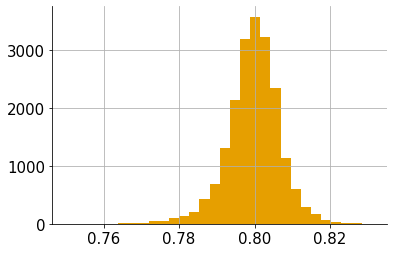

In [47]:
R_0 = np.zeros([initN.size,len(samples_dict['beta'])])
for i in range(len(samples_dict['beta'])):
    R_0[:,i]= (model.parameters['a']*model.parameters['da']+model.parameters['omega'])*samples_dict['beta'][i]*model.parameters['s']*np.sum(Nc_total,axis=1)
plt.hist(R_0[8,:],bins=30)

means=np.zeros(R_0.shape[0])
for i in range(R_0.shape[0]):
    mean = np.mean(R_0[i,:])
    means[i]=mean
    p10 = np.percentile(R_0[i,:],10)
    p90 = np.percentile(R_0[i,:],90)
    print(mean,p10,p90)

In [48]:
# define dataset
data=[df_sciensano["H_in"].values[:51]]
states = [["H_in"]]
start_date = '15-03-2020'

T = 2

n=100
csum_save=np.zeros([n,9])
for i in range(n):
    model.parameters['beta'] = np.random.choice(samples_dict['beta'],1,replace=False)
    idx,model.parameters['l'] = random.choice(list(enumerate(samples_dict['l'])))
    model.parameters['tau'] = samples_dict['tau'][idx]
    model.parameters['prevention'] = samples_dict['prevention'][idx]
    y_model = model.sim(data[0].size+samples_dict['lag_time']-1+T)
    
    # Create shifted index vector 
    idx = pd.date_range(start_date,freq='D',periods=data[0].size + samples_dict['lag_time'] + T) - datetime.timedelta(days=samples_dict['lag_time'])

    # ages i plus
    data2plot = y_model[states[0]].to_array(dim="states").values.ravel()
    val = y_model[states[0]].to_array(dim="states").values[-1,:,:].sum(axis=1)
    #csum_iplus=np.cumsum(val)
    csum_iplus=val
    csum_save[i,:]=np.reshape((csum_iplus/sum(csum_iplus)),(1,(csum_iplus/sum(csum_iplus)).size))*100
    #csum_save[i,:] = csum_iplus/csum_iplus[-1]
csum_hosp_mean = csum_save.mean(axis=0)
csum_hosp_p10 = np.percentile(csum_save,10,axis=0)
csum_hosp_p90 = np.percentile(csum_save,90,axis=0)

<ipython-input-49-0dc83a1cfc8b>:15: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "papertype" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('../results/calibration_non_spatial_deterministic/R_naught_cumulative_hospitalisations.pdf', dpi=300, bbox_inches='tight',orientation='portrait', papertype='a4')


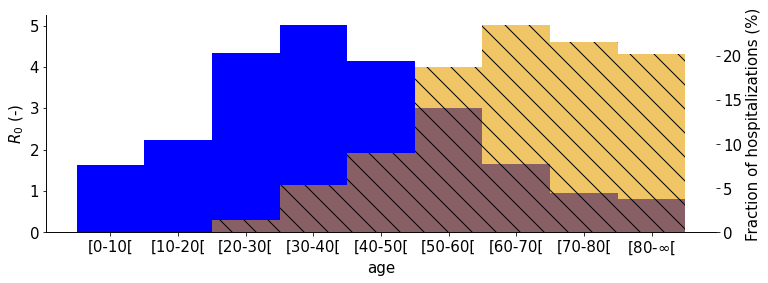

In [49]:
fig,ax1=plt.subplots()

ax1.bar(np.arange(R_0.shape[0]),means,1,color='blue')
ax1.set_xlabel('age')
ax1.set_ylabel('$R_0$ (-)')
ax1.grid(False)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.bar(np.arange(R_0.shape[0]),csum_hosp_mean,1,alpha=0.6,hatch="\\")
ax2.set_xlabel('age')
ax2.set_ylabel('Fraction of hospitalizations (%)')
ax2.grid(False)
plt.xticks(np.arange(9), ('[0-10[', '[10-20[', '[20-30[', '[30-40[', '[40-50[', '[50-60[', '[60-70[', '[70-80[', '[80-$\infty$['))
fig.set_size_inches(12, 4)
plt.savefig('../results/calibration_non_spatial_deterministic/R_naught_cumulative_hospitalisations.pdf', dpi=300, bbox_inches='tight',orientation='portrait', papertype='a4')

### Re-estimating beta

In [50]:
# Define the compliance and lockdown function
def lockdown_func(t,param,policy_time,policy1,policy2,l,tau,prevention):
    if t <= policy_time + tau:
        return policy1
    elif policy_time + tau < t <= policy_time + tau + l:
        return policy1 + (prevention*policy2-policy1)/l*(t-policy_time-tau)
    else:
        return prevention*policy2

In [51]:
def beta_reestimate_func(t,param,change_beta_time,beta_old,beta_new):
    if t <= change_beta_time:
        return beta_old
    elif change_beta_time < t <= change_beta_time+120:
        return beta_new
    else:
        return beta_new

In [52]:
# Load previous samples
with open('../data/interim/model_parameters/deterministic_'+datetime.datetime.today().strftime('%Y-%m-%d') +'.json', 'r') as fp:
    samples_dict = json.load(fp)

In [53]:
# Load the parameters using `get_COVID19_SEIRD_parameters()`.
params = model_parameters.get_COVID19_SEIRD_parameters()
# Define the initial condition: one exposed inidividual in every age category
initial_states = {'S': initN, 'E': np.ones(levels)}
# Add all time-dependent parameters to function definition
params.update({'policy1': Nc_total,
              'policy2': 1.0*Nc_home + (1-0.60)*Nc_work + (1-0.70)*Nc_transport + (1-0.30)*Nc_others + (1-0.80)*Nc_leisure,
              'policy_time': samples_dict['lag_time'],
              'l': np.mean(samples_dict['l']),
              'tau': np.mean(samples_dict['tau']),
              'prevention': np.mean(samples_dict['prevention']),
               'change_beta_time': np.mean(samples_dict['lag_time'])+50,
               'beta_old': np.mean(samples_dict['beta']),
               'beta_new': 0.06})
# Initialise the model
model = models.COVID19_SEIRD(initial_states, params, time_dependent_parameters={'Nc': lockdown_func, 'beta': beta_reestimate_func})

In [54]:
model.extraTime = samples_dict['lag_time']
model.parameters['beta'] = np.mean(samples_dict['beta'])
model.parameters['l'] = np.mean(samples_dict['l'])
model.parameters['tau'] = np.mean(samples_dict['tau'])
model.parameters['prevention'] = np.mean(samples_dict['prevention'])

In [55]:
T = 62
from copy import deepcopy
# define dataset
data=[df_sciensano["H_in"].values[:]]
# Redine lag_time
model.extraTime = samples_dict['lag_time']
# define samples_dict without lag_time
smpls=deepcopy(samples_dict)
del smpls['lag_time']
# set optimisation settings
parNames = ['sigma_H_in','beta_new'] # must be a list!
states = [["H_in"]]
bounds=((1,500),(0.001,0.06)) # must be a list!

In [56]:
# run optimisation
theta = MCMC.fit_pso(model,data,parNames,states,bounds,samples=smpls,maxiter=50,popsize=20)

No constraints given.
New best for swarm at iteration 1: [1.03223564e+02 5.52694162e-02] 967.415155835764
Best after iteration 1: [1.03223564e+02 5.52694162e-02] 967.415155835764
New best for swarm at iteration 2: [5.72996498e+01 1.00000000e-03] 891.4818397745754
Best after iteration 2: [5.72996498e+01 1.00000000e-03] 891.4818397745754
Best after iteration 3: [5.72996498e+01 1.00000000e-03] 891.4818397745754
Best after iteration 4: [5.72996498e+01 1.00000000e-03] 891.4818397745754
Best after iteration 5: [5.72996498e+01 1.00000000e-03] 891.4818397745754
New best for swarm at iteration 6: [5.86143298e+01 1.00000000e-03] 879.185014520443
Best after iteration 6: [5.86143298e+01 1.00000000e-03] 879.185014520443
New best for swarm at iteration 7: [5.42044761e+01 1.00000000e-03] 872.1476922846537
Best after iteration 7: [5.42044761e+01 1.00000000e-03] 872.1476922846537
Best after iteration 8: [5.42044761e+01 1.00000000e-03] 872.1476922846537
Best after iteration 9: [5.42044761e+01 1.00000000

In [57]:
parNames = ['sigma_ICU','beta_new'] # must be a list!
bounds=((1,200),(0.0001,0.20))

pos = [theta[0],theta[1]] + [1, 1e-2 ]* np.random.randn(8, 2)
nwalkers, ndim = pos.shape
sampler = emcee.EnsembleSampler(nwalkers, ndim, objective_fcns.log_probability,
                                args=(model,bounds,data,states,parNames,smpls))
sampler.run_mcmc(pos, 1000, progress=True);

  0%|          | 0/500 [00:00<?, ?it/s]/home/twallema/anaconda3/envs/COVID_MODEL/lib/python3.8/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 500/500 [05:11<00:00,  1.60it/s]


In [58]:
samples = sampler.get_chain(discard=100,flat=False)
flat_samples = sampler.get_chain(discard=100,flat=True)

In [59]:
# Calculate the autocorrelation time
try:
    print(sampler.get_autocorr_time())
except:
    print('The chain is shorter than 50 times the integrated autocorrelation time.')

The chain is shorter than 50 times the integrated autocorrelation time.


In [60]:
mean = np.mean(flat_samples[:,1])
p10 = np.percentile(flat_samples[:,1],10)
p90 = np.percentile(flat_samples[:,1],90)
print(mean,p10,p90)

0.06035435457147051 0.05706839312423164 0.06325335615126233


In [61]:
samples_dict.update({'beta_new': flat_samples[:,1].tolist()})

In [62]:
with open('../data/interim/model_parameters/deterministic_'+ datetime.datetime.today().strftime('%Y-%m-%d')+'.json', 'w') as fp:
    json.dump(samples_dict, fp)

<AxesSubplot:xlabel='step number', ylabel='beta_new'>

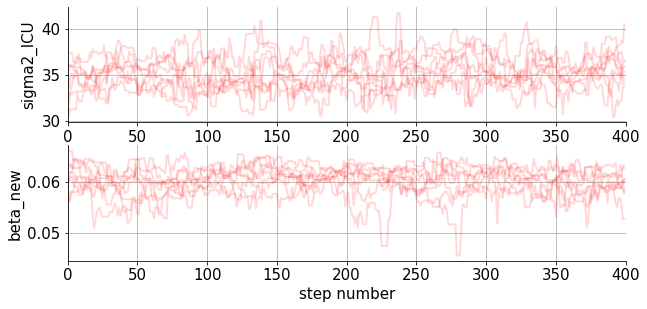

In [63]:
traceplot(samples,labels=["sigma2_ICU","beta_new"],plt_kwargs={'linewidth':2,'color': 'red','alpha': 0.15})

<ipython-input-64-3a2dc3afe2ca>:7: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "papertype" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('../results/calibration_non_spatial_deterministic/corner_beta.pdf', dpi=600, bbox_inches='tight',


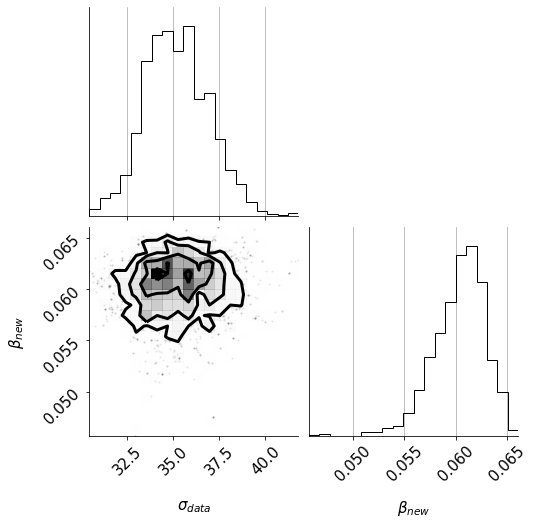

In [64]:
import corner

fig = corner.corner(
    flat_samples,labels=['$\sigma_{data}$','$\\beta_{new}$']
);
fig.set_size_inches(8, 8)
plt.savefig('../results/calibration_non_spatial_deterministic/corner_beta.pdf', dpi=600, bbox_inches='tight',
                    orientation='portrait', papertype='a4')

In [65]:
# define dataset
data=[df_sciensano["H_tot"].values[:],df_sciensano["ICU_tot"].values[:]]
states = [["H_tot"],["ICU"]]

<ipython-input-66-df54aaea604f>:19: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "papertype" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('../results/calibration_non_spatial_deterministic/plot_fit_beta.pdf', dpi=600, bbox_inches='tight',orientation='portrait', papertype='a4')


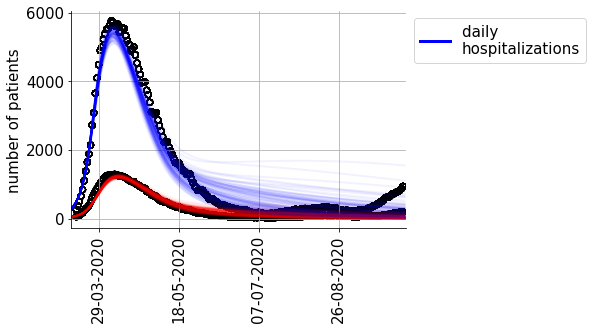

In [66]:
T = 1
start_date='15-03-2020'
#data=[df_sciensano["H_in"].values[:]]

fig,ax=plt.subplots()
for i in range(100):
    model.parameters['beta'] = np.random.choice(samples_dict['beta'],1,replace=False)
    idx,model.parameters['l'] = random.choice(list(enumerate(samples_dict['l'])))
    model.parameters['tau'] = samples_dict['tau'][idx]
    model.parameters['prevention'] = samples_dict['prevention'][idx]
    model.parameters['beta_new'] = np.random.choice(samples_dict['beta_new'],1,replace=False)

    y_model = model.sim(data[0].size+samples_dict['lag_time']-1+T)
    ax = plot_fit(y_model,data,start_date,samples_dict['lag_time'],states,T=T,ax=ax,plt_kwargs={'linewidth': 2,'alpha': 0.05})
    
#plt.scatter(pd.date_range('15-03-2020',freq='D',periods=df_sciensano["H_in"][:50].size),df_sciensano["H_in"][:50], marker='o',color='red',linestyle='None',facecolors='none')
legend_text=['daily \nhospitalizations']
leg=ax.legend(legend_text, loc="upper left", bbox_to_anchor=(1,1))
plt.savefig('../results/calibration_non_spatial_deterministic/plot_fit_beta.pdf', dpi=600, bbox_inches='tight',orientation='portrait', papertype='a4')

#### Re-compute the basic reproduction number

In [67]:
R_0 = (model.parameters['a']*model.parameters['da']+model.parameters['omega'])*mean*model.parameters['s']*np.sum(Nc_total,axis=1)